## OCR Report
This notebook constructs a proof-of-concept report of the district level data of Washington State schools, describing discipline and attendance information and highlighting disproportionate areas. See the README [here](https://github.com/CBofill/OCR-Discipline-and-Attendance-Visualization-Tool) for more information.

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
input_file = './data/NeedDistrict_Part2.csv'
output_file = './calculated_data.csv'

In [3]:
# Import the data
df = pd.read_csv(input_file,index_col='SCH_ID')

In [4]:
df.replace('Yes', True, inplace=True)
df.replace('No', False, inplace=True)

In [5]:
## get list of grades
grades = [x.strip() for x in re.findall('SCH_GRADE_...', ' '.join(df.columns))]

## create variable for grades in a given school
school_grade_span = []
for row in df.iterrows():
    span = [re.sub('SCH_GRADE_', '', g) for g in grades if row[1][g]]
    school_grade_span.append((span[0], span[-1]))
## add grade span to data set
df['school_grade_span'] = pd.Series(school_grade_span, index=df.index)

## Enrollment
Enrollment is provided by race/ethnicity separated by gender. It is similarly provided for LEP (Limited English Proficiency) students and students with disabilities (IDEA/504). Counts for these three are not mutually exclusive, e.g. a student covered by IDEA will be included in the IDEA enrollment count as well as the count for their race/ethnicity. 

The total for each race/ethnicity is calculated, as well as the total students enrolled in each school.

Abbreviation-race pairs:

    - HI: Hispanic
    - AM: American Indian/ Alaksan Native
    - AS: Asian
    - HP: Native Hawaiian/Pacific Islander
    - BL: Black
    - WH: White
    - TR: Two or more

In [171]:
## get list of columns with enrollment data
enrollment_columns = [x for x in re.findall('SCH_ENR_.._[MF]', ' '.join(df.columns))]
enrollment_columns.extend(['school_grade_span'])

#get just enrollment data
enrollment_data = df.loc[:,enrollment_columns]
#clean up names of columns
enrollment_data.columns = [re.sub('SCH_ENR_', '', x) for x in enrollment_data.columns]

# add columns representing all male and female members of given race
race_abbreviations = ['HI', 'AM', 'AS', 'HP', 'BL', 'WH', 'TR']
for r in race_abbreviations:
    enrollment_data[r] = enrollment_data[re.findall(r + '_.', ' '.join(enrollment_data.columns))].sum(axis=1)


# add column for male and female
gender = ['M', 'F']
for g in gender:
    enrollment_data[g] = enrollment_data[re.findall( '.._' + g, ' '.join(enrollment_data.columns))].sum(axis=1)

enrollment_data_clean = enrollment_data.ix[:,-9:]
enrollment_data_clean['total'] = enrollment_data_clean.iloc[:,-2:].sum(axis=1)

In [172]:
enrollment_data_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,28,2,3,0,2,109,14,80,78,158
530003000010,134,10,1,1,2,183,26,168,189,357
530003000008,109,5,4,0,3,210,29,176,184,360
530003000011,185,25,16,0,9,248,37,274,246,520
530003000001,180,13,8,0,3,198,17,214,205,419
530003000009,119,30,13,2,6,268,18,218,238,456
530003000007,257,33,30,6,8,548,39,477,444,921
530003000002,25,5,1,1,4,62,8,58,48,106
530003002055,9,1,0,0,1,12,0,14,9,23


**Question**: Are there really only 23 students in school 530003002055?

In [173]:
# get enrollment data proportions
enrollment_data_proportions = enrollment_data_clean.copy()
for i in xrange(enrollment_data_proportions.shape[0]):
    for j in xrange(enrollment_data_proportions.shape[1]):
        enrollment_data_proportions.iloc[i, j] = enrollment_data_proportions.iloc[i, j]*1.0 / enrollment_data_proportions.iloc[i, -1]

In [174]:
# create df for presenting enrollment data
enrollment_presentation = enrollment_data_proportions.round(decimals=2)
enrollment_presentation.drop('total', axis=1, inplace=True)
enrollment_presentation

,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,
530003000005,0.18,0.01,0.02,0.00,0.01,0.69,0.09,0.51,0.49
530003000010,0.38,0.03,0.00,0.00,0.01,0.51,0.07,0.47,0.53
530003000008,0.30,0.01,0.01,0.00,0.01,0.58,0.08,0.49,0.51
530003000011,0.36,0.05,0.03,0.00,0.02,0.48,0.07,0.53,0.47
530003000001,0.43,0.03,0.02,0.00,0.01,0.47,0.04,0.51,0.49
530003000009,0.26,0.07,0.03,0.00,0.01,0.59,0.04,0.48,0.52
530003000007,0.28,0.04,0.03,0.01,0.01,0.60,0.04,0.52,0.48
530003000002,0.24,0.05,0.01,0.01,0.04,0.58,0.08,0.55,0.45
530003002055,0.39,0.04,0.00,0.00,0.04,0.52,0.00,0.61,0.39


## In-School Suspensions
In-school suspension data are provided by race/ethnicity separated by gender and students with and without disabilites. The percentage rate of students who received one or more in-school suspension is summed by race/ethnicity, then the composition index is calculated.

In [175]:
## get list of columns with ISS data
iss_columns = [x for x in re.findall('SCH_DISCWODIS_ISS_.._[MF]', ' '.join(df.columns))]
# how were these fields chosen?
iss_columns.extend([x for x in re.findall('SCH_DISCWDIS_ISS_IDEA_.._[MF]', ' '.join(df.columns))])
iss_columns.extend(['school_grade_span'])

#get just iss data
iss_df = df[iss_columns]
#clean up names of columns
iss_df.columns = [re.sub('SCH_DISCWODIS_ISS_', '', x) for x in iss_df.columns]
iss_df.columns = [re.sub('SCH_DISCWDIS_ISS_IDEA_', '', x) for x in iss_df.columns]
iss_df = iss_df.groupby(by = iss_df.columns, axis=1).sum()

# add columns representing all male and female members of given race
for r in race_abbreviations:
    iss_df[r] = iss_df[re.findall(r + '_.', ' '.join(iss_df.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    iss_df[g] = iss_df[re.findall( '.._' + g, ' '.join(iss_df.columns))].sum(axis=1)

In [176]:
# get clean iss data
iss_df_clean = iss_df.iloc[:, -9:]
iss_df_clean['total'] = iss_df_clean.iloc[:,-2:].sum(axis=1)
iss_df_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0,0,0,0,0,1,0,1,0,1
530003000010,0,0,0,0,0,2,2,4,0,4
530003000008,0,0,0,0,0,1,0,1,0,1
530003000011,0,0,0,0,0,1,0,1,0,1
530003000001,0,1,0,0,0,4,0,4,1,5
530003000009,1,1,0,0,0,13,0,6,9,15
530003000007,13,5,0,2,3,30,7,45,15,60
530003000002,0,0,0,0,0,0,0,0,0,0
530003002055,0,0,0,0,0,0,0,0,0,0


In [184]:
# get iss proportions
iss_proportions = iss_df_clean.copy()
for i in xrange(iss_proportions.shape[0]):
    for j in xrange(iss_proportions.shape[1]):
        if iss_proportions.iloc[i, -1] != 0:
            iss_proportions.iloc[i, j] = iss_proportions.iloc[i, j]*1.0 / iss_proportions.iloc[i, -1]

In [185]:
# create df for displaying iss data
iss_presentation = iss_proportions.round(decimals=2)
iss_presentation.drop('total', axis=1, inplace=True)
iss_presentation

,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,
530003000005,0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000010,0.00,0.00,0.0,0.00,0.00,0.50,0.50,1.00,0.00
530003000008,0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000011,0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000001,0.00,0.20,0.0,0.00,0.00,0.80,0.00,0.80,0.20
530003000009,0.07,0.07,0.0,0.00,0.00,0.87,0.00,0.40,0.60
530003000007,0.22,0.08,0.0,0.03,0.05,0.50,0.12,0.75,0.25
530003000002,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
530003002055,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


## Out-of-School Suspensions
Out-of-school suspension data are provided by race/ethnicity separated by gender, students with and without disabilities, and students receiving only one or more than one suspension. The percentage rate of students who received one or more out-of-school suspension is summed by race/ethnicity, and the composition index is calculated.

In [179]:
"""
## get list of columns with OOS suspension data
oos_columns = [x for x in re.findall('SCH_DISCWODIS_(MULT|SING)OOS_.._(M|F)', ' '.join(df.columns))]
oos_columns.extend([x for x in re.findall('SCH_DISCWDIS_(MULT|SING)OOS_IDEA_.._(M|F)', ' '.join(df.columns))])
oos_columns.extend(['school_grade_span'])

#get just oos data
oos_df = df[oos_columns]
#clean up names of columns
oos_df.columns = [re.sub('SCH_DISCWODIS_....OOS_', '', x) for x in oos_df.columns]
oos_df.columns = [re.sub('SCH_DISCWDIS_....OOS_IDEA_', '', x) for x in oos_df.columns]
oos_df = oos_df.groupby(by = oos_df.columns, axis=1).sum()

# add columns representing all male and female members of given race
for r in race_abbreviations:
    oos_df[r] = oos_df[re.findall(r + '_.', ' '.join(oos_df.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    oos_df[g] = oos_df[re.findall( '.._' + g, ' '.join(oos_df.columns))].sum(axis=1)
""";

## Expulsions
Expulsions data are provided by race/ethnicity separated by gender, students with and without disabilities, and students who received an expulsion with or without educational services. The percentage rate of students who received an expulsion is summed by race/ethnicity, and the composition index is calculated.

In [ ]:
"""# Calculate expulsion totals
expulsion_data = pd.DataFrame()

for race in race_abbreviations:
    expulsion_data[race] = data[['SCH_PSDISC_EXP_'+race+'_M','SCH_PSDISC_EXP_'+race+'_F',
                                            'SCH_DISCWODIS_EXPWE_'+race+'_M','SCH_DISCWODIS_EXPWE_'+race+'_F',
                                            'SCH_DISCWODIS_EXPWOE_'+race+'_M','SCH_DISCWODIS_EXPWOE_'+race+'_F',
                                            'SCH_DISCWDIS_EXPWE_IDEA_'+race+'_M','SCH_DISCWDIS_EXPWE_IDEA_'+race+'_F',
                                            'SCH_DISCWDIS_EXPWOE_IDEA_'+race+'_M',
                                             'SCH_DISCWDIS_EXPWOE_IDEA_'+race+'_F']].sum(axis=1)
expulsion_data['total'] = expulsion_data.sum(axis=1)
    
# Calculate expulsion percentages
for race in race_abbreviations:
    expulsion_data[race+'_p'] = expulsion_data[race]/expulsion_data['total']
    
# Calculate composition index
for race in race_abbreviations:
    expulsion_data[race+'_comp'] = expulsion_data[race+'_p']/enrollment_data[race+'_p']
    """

## Visualization

In [180]:
iss_proportions

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0,0.000000,0.0,0.000000,0.00,1.000000,0.000000,1.00,0.00,1.0
530003000010,0,0.000000,0.0,0.000000,0.00,0.500000,0.500000,1.00,0.00,1.0
530003000008,0,0.000000,0.0,0.000000,0.00,1.000000,0.000000,1.00,0.00,1.0
530003000011,0,0.000000,0.0,0.000000,0.00,1.000000,0.000000,1.00,0.00,1.0
530003000001,0,0.200000,0.0,0.000000,0.00,0.800000,0.000000,0.80,0.20,1.0
530003000009,1,0.066667,0.0,0.000000,0.00,0.866667,0.000000,0.40,0.60,1.0
530003000007,13,0.083333,0.0,0.033333,0.05,0.500000,0.116667,0.75,0.25,1.0
530003000002,0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0
530003002055,0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0


In [181]:
enrollment_data_proportions

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0.177215,0.012658,0.018987,0.000000,0.012658,0.689873,0.088608,0.506329,0.493671,1.0
530003000010,0.375350,0.028011,0.002801,0.002801,0.005602,0.512605,0.072829,0.470588,0.529412,1.0
530003000008,0.302778,0.013889,0.011111,0.000000,0.008333,0.583333,0.080556,0.488889,0.511111,1.0
530003000011,0.355769,0.048077,0.030769,0.000000,0.017308,0.476923,0.071154,0.526923,0.473077,1.0
530003000001,0.429594,0.031026,0.019093,0.000000,0.007160,0.472554,0.040573,0.510740,0.489260,1.0
530003000009,0.260965,0.065789,0.028509,0.004386,0.013158,0.587719,0.039474,0.478070,0.521930,1.0
530003000007,0.279045,0.035831,0.032573,0.006515,0.008686,0.595005,0.042345,0.517915,0.482085,1.0
530003000002,0.235849,0.047170,0.009434,0.009434,0.037736,0.584906,0.075472,0.547170,0.452830,1.0
530003002055,0.391304,0.043478,0.000000,0.000000,0.043478,0.521739,0.000000,0.608696,0.391304,1.0


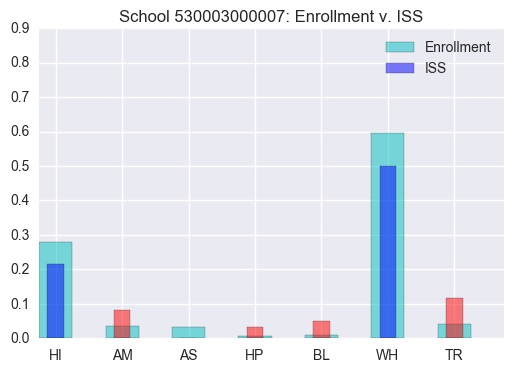

In [186]:
school_enrollment = enrollment_data_proportions.iloc[6,:-3].values
school_iss = iss_proportions.iloc[6,:-3].values
indices = range(len(race_abbreviations))
width = 0.5

composition = school_iss / school_enrollment

flagging = []
for r in composition:
    if r > 1.0:
        flagging.extend('r')
    else:
        flagging.extend('b')

plt.bar(indices, school_enrollment, color='c', alpha = 0.5, width=width, label='Enrollment')
plt.bar([i+0.25*width for i in indices], school_iss, color=flagging, width = 0.5*width, alpha=0.5, label='ISS')


plt.xticks([i+0.5*width for i in indices], race_abbreviations)
plt.title('School {}: Enrollment v. ISS'.format(enrollment_data_clean.index[6]))
plt.ylim(0, 0.9)
plt.legend()
plt.show()